In [1]:
#!pip install ipywidgets

In [103]:
import pandas as pd
import urllib.parse
import matplotlib.pyplot as plt
import numpy as np
import ffkkmo_ra
import ipywidgets as widgets

Получим датасет

In [104]:
df = pd.read_csv("ffkkmo_clean.csv", index_col='Unnamed: 0')

In [105]:
clubs = sorted(list(filter(lambda x : isinstance(x, str), df.club.unique())))
categoies = df.category.unique()
club = widgets.Dropdown(
    options=clubs,
    value=clubs[0],
    description='Школа:',
    disabled=False,
)
category = widgets.Dropdown(
    options=categoies,
    value=categoies[0],
    description='Разряд:',
    disabled=False,
)
limit_val = widgets.IntSlider(
    value=50,
    min=0,
    max=200,
    step=1,
    description='Количество:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
season = widgets.Dropdown(
    options=[2021, 2122, 2223, 2324, 2425],
    value=2425,
    description='Сезон:',
    disabled=False,
)

In [106]:
display(club)
display(category)
display(season)
display(limit_val)

Dropdown(description='Школа:', options=('Балашиха, АНО ДЮСШ «Олимп»', 'Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина…

Dropdown(description='Разряд:', options=('3-й юношеский разряд, мальчики', '3-й юношеский разряд, девочки', '2…

Dropdown(description='Сезон:', index=4, options=(2021, 2122, 2223, 2324, 2425), value=2425)

IntSlider(value=50, continuous_update=False, description='Количество:', max=200)

In [107]:
ffkkmo_ra.get_top_df(df, 5)

Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»                    2495
Щелково, МАУ ГОЩ «ФОК «Ледовая арена» им. В.А. Третьяка     1967
Одинцово, МБУ ДО СШ «Одинцово»                              1911
Лыткарино, МАУ «ЛСК Лыткарино»                              1844
Наро-Фоминский, МАУ ДО ЦСШ №1                               1662
Остальные                                                  19816
Name: club, dtype: int64

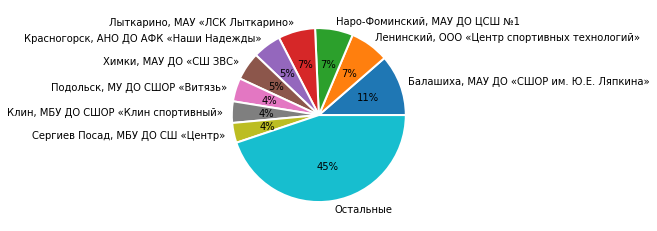

In [108]:
ffkkmo_ra.pie_of_winners(df, 2425, 3, 9, "Доля призеров в сезоне 24-25")
plt.title("", fontsize=16)
plt.xlabel("", fontsize=18)
plt.ylabel("", fontsize=18);

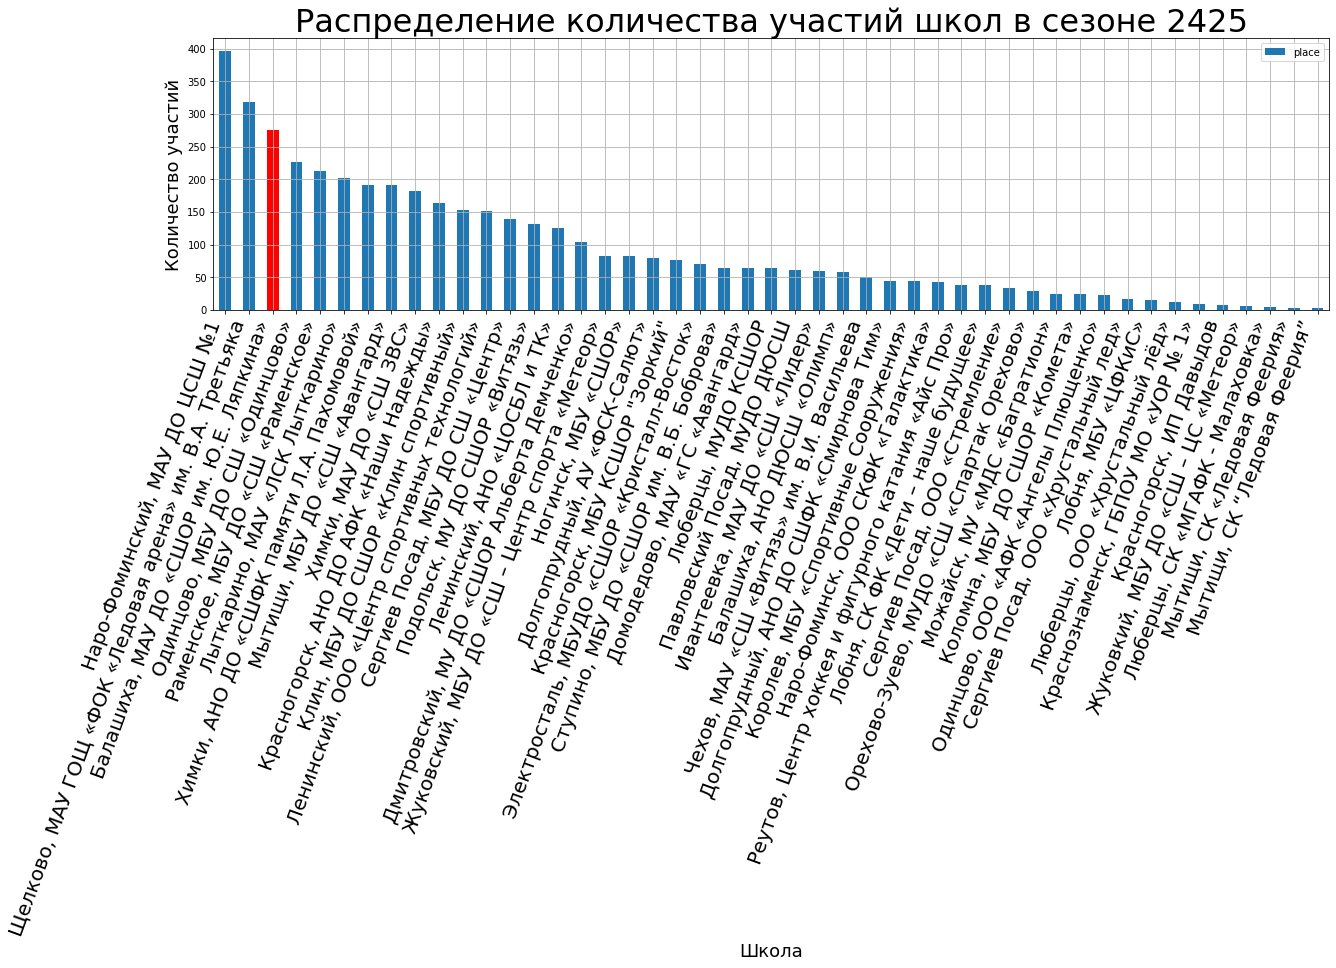

In [109]:
ffkkmo_ra.plot_clubs_in_season(df, season.value, limit_val.value, club.value)

In [110]:
ffkkmo_ra.get_df_of_club_in_season(df, club.value, season.value)

,date,place,online,category,segment,rank,firstname,middlename,lastname,club,tss,tes,pcs,year,month,season
0,2024-09-14,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin09/,"2-й спортивный разряд, девочки",Короткая программа,2,Елизавета,NaN,ЧЕРЕПАНОВА,"Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»",29.22,16.25,13.47,2024,9,2425
1,2024-09-14,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin09/,"2-й спортивный разряд, девочки",Короткая программа,3,Милана,NaN,МОСЯГИНА,"Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»",25.43,11.83,14.10,2024,9,2425
2,2024-09-14,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin09/,"2-й спортивный разряд, девочки",Произвольная программа,1,Милана,NaN,МОСЯГИНА,"Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»",61.14,30.98,30.66,2024,9,2425
3,2024-09-14,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin09/,"2-й спортивный разряд, девочки",Произвольная программа,2,Елизавета,NaN,ЧЕРЕПАНОВА,"Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»",58.04,29.20,28.84,2024,9,2425
4,2024-09-14,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin09/,"1-й спортивный разряд, девочки",Короткая программа,1,Елизавета,NaN,ШИРЯЕВА,"Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»",59.12,33.37,25.75,2024,9,2425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,2025-05-24,"г. Электросталь, ул. Радио, д. 3, ЛДС ""Кристалл""",http://ffkkmo.ru/events/2425/el05/,"3-й спортивный разряд, девочки",Произвольная программа,6,Арина,Андреевна,ЕРЫГИНА,"Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»",35.56,16.91,21.15,2025,5,2425
403,2025-05-24,"г. Электросталь, ул. Радио, д. 3, ЛДС ""Кристалл""",http://ffkkmo.ru/events/2425/el05/,"2-й спортивный разряд, девочки",Короткая программа,7,Алена,Алексеевна,КРУПИНА,"Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»",28.75,14.04,14.71,2025,5,2425
404,2025-05-24,"г. Электросталь, ул. Радио, д. 3, ЛДС ""Кристалл""",http://ffkkmo.ru/events/2425/el05/,"2-й спортивный разряд, девочки",Произвольная программа,5,Алена,Алексеевна,КРУПИНА,"Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»",53.29,24.29,29.00,2025,5,2425
405,2025-05-24,"г. Электросталь, ул. Радио, д. 3, ЛДС ""Кристалл""",http://ffkkmo.ru/events/2425/el05/,"Юный фигурист, девочки",Произвольная программа,3,Лусинэ,Сергеевна,ТЕПОЯН,"Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»",11.75,5.75,6.00,2025,5,2425


In [111]:
# ffkkmo_ra.sportsmen_rating_in_season(df, season.value, category.value, 'Мария', 'ТУЛАЕВА', limit=limit_val.value)

,date,firstname,lastname,club,rank,tss,tes,pcs,year,month,season,label


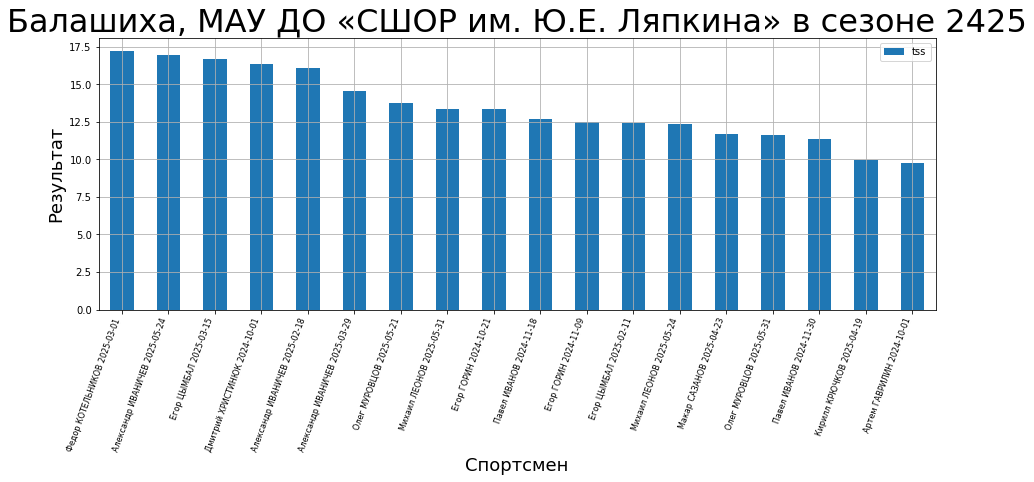

In [112]:
ffkkmo_ra.club_rating_in_season(df, season.value, category.value, club.value, limit=limit_val.value)

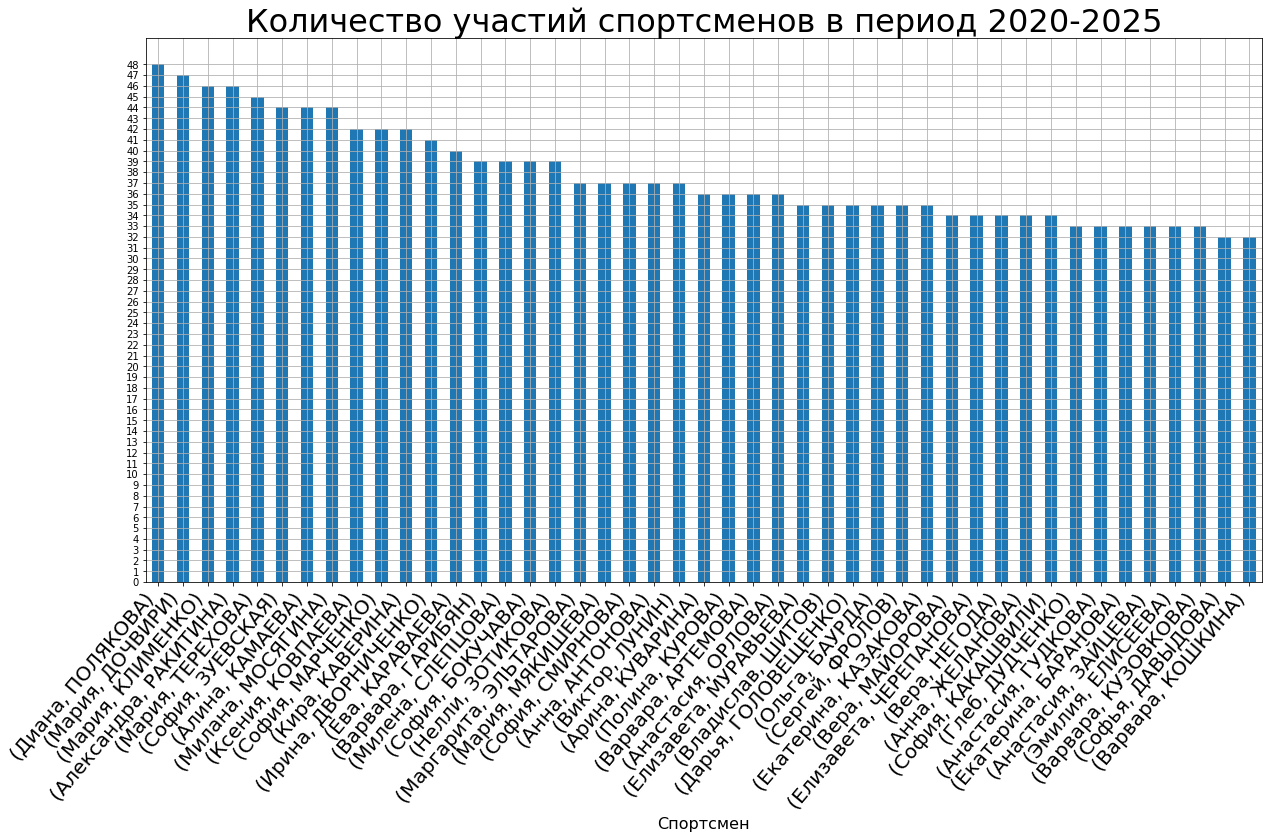

In [113]:
data = df[df['segment']=='Произвольная программа'].groupby(['firstname', 'lastname']).count().sort_values(
    by='date', ascending=False).head(45)['date']
ax = data.plot(
    kind='bar', figsize=(20, 10), grid=True
)
major_ticks = np.arange(0, max(data) + 1, 1)
ax.set_yticks(major_ticks)
plt.title("Количество участий спортсменов в период 2020-2025", fontsize=32)
plt.xlabel('Спортсмен', fontsize=16)
plt.ylabel(f'', fontsize=18)
plt.xticks(fontsize=20, rotation=50, horizontalalignment='right');

In [114]:
df[df['category'].isin(categoies)&(df['season']==2425)].sort_values(by="tss").groupby(["category", "segment"]).last()[['club', 'date', 'firstname', 'lastname', 'tss', 'tes', 'pcs']]

club  \
category                        segment                                                                 
1-й спортивный разряд, девочки  Короткая программа           Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»   
                                Произвольная программа   Ленинский, ООО «Центр спортивных технологий»   
1-й спортивный разряд, мальчики Короткая программа                    Сергиев Посад, ООО «Стремление»   
                                Произвольная программа                Сергиев Посад, ООО «Стремление»   
1-й юношеский разряд, девочки   Произвольная программа        Ступино, МБУ ДО «СШОР им. В.Б. Боброва»   
1-й юношеский разряд, мальчики  Произвольная программа                Сергиев Посад, ООО «Стремление»   
2-й спортивный разряд, девочки  Короткая программа       Ленинский, ООО «Центр спортивных технологий»   
                                Произвольная программа           Одинцово, ООО «АФК «Ангелы Плющенко»   
2-й спортивный разряд, мальчики Короткая программа                  Раменское, МБУ ДО «СШ «Раменское»   
                                Произвольная программа                 Лыткарино, МАУ «ЛСК Лыткарино»   
2-й юношеский разряд, девочки   Произвольная программа                  Мытищи, МБУ ДО «СШ «Авангард»   
2-й юношеский разряд, мальчики  Произвольная программа       Долгопрудный, АНО ДО СШФК «Смирнова Тим»   
3-й спортивный разряд, девочки  Произвольная программа                  Подольск, МУ ДО СШОР «Витязь»   
3-й спортивный разряд, мальчики Произвольная программа                            Люберцы, МУДО КСШОР   
3-й юношеский разряд, девочки   Произвольная программа         Красногорск, АНО ДО АФК «Наши Надежды»   
3-й юношеский разряд, мальчики  Произвольная программа       Долгопрудный, АНО ДО СШФК «Смирнова Тим»   
КМС, юноши                      Короткая программа               Одинцово, ООО «АФК «Ангелы Плющенко»   
                                Произвольная программа           Одинцово, ООО «АФК «Ангелы Плющенко»   
МС юноши                        Короткая программа               Одинцово, ООО «АФК «Ангелы Плющенко»   
                                Произвольная программа           Одинцово, ООО «АФК «Ангелы Плющенко»   
МС, девушки                     Короткая программа       Ленинский, ООО «Центр спортивных технологий»   
                                Произвольная программа           Одинцово, ООО «АФК «Ангелы Плющенко»   
Младшая группа, девочки         Короткая программа       Ленинский, ООО «Центр спортивных технологий»   
                                Произвольная программа   Ленинский, ООО «Центр спортивных технологий»   
Младшая группа, мальчики        Короткая программа                     Одинцово, МБУ ДО СШ «Одинцово»   
                                Произвольная программа              Раменское, МБУ ДО «СШ «Раменское»   
Старшая группа, девочки         Короткая программа       Ленинский, ООО «Центр спортивных технологий»   
                                Произвольная программа   Ленинский, ООО «Центр спортивных технологий»   
Старшая группа, мальчики        Короткая программа                    Сергиев Посад, ООО «Стремление»   
                                Произвольная программа                Сергиев Посад, ООО «Стремление»   
Юный фигурист, девочки          Катание под музыку                     Лыткарино, МАУ «ЛСК Лыткарино»   
                                Произвольная программа  Жуковский, МБУ ДО «СШ – Центр спорта «Метеор»   
Юный фигурист, мальчики         Катание под музыку                     Лыткарино, МАУ «ЛСК Лыткарино»   
                                Произвольная программа              Раменское, МБУ ДО «СШ «Раменское»   

                                                              date  firstname  \
category                        segment                                         
1-й спортивный разряд, девочки  Короткая программа      2024-09-14  Елизавета   
                                Произвольная программа  2025-03-29     Ан

In [115]:
df[(df['season']==2425)].groupby("category").count()['date']

category
1-й спортивный разряд, девочки      914
1-й спортивный разряд, мальчики      72
1-й юношеский разряд, девочки       448
1-й юношеский разряд, мальчики       27
2-й спортивный разряд, девочки     1323
2-й спортивный разряд, мальчики      50
2-й юношеский разряд, девочки       881
2-й юношеский разряд, мальчики       76
3-й спортивный разряд, девочки      747
3-й спортивный разряд, мальчики      62
3-й юношеский разряд, девочки       619
3-й юношеский разряд, мальчики       18
КМС, юноши                           30
МС юноши                             12
МС, девушки                         108
Младшая группа, девочки              59
Младшая группа, мальчики             10
Старшая группа, девочки              60
Старшая группа, мальчики              8
Юный фигурист, девочки              182
Юный фигурист, мальчики              16
Name: date, dtype: int64

In [116]:
df_groupped[(df_groupped['season'] == 2223) & (df_groupped['club'] == 'Люберцы, МУДО КСШОР')].count()

firstname     25
lastname      25
club          25
season        25
date          25
place         25
online        25
category      25
segment       25
rank          25
middlename     0
tss           25
tes           25
pcs           25
year          25
month         25
tes_min       24
tes_done      25
dtype: int64

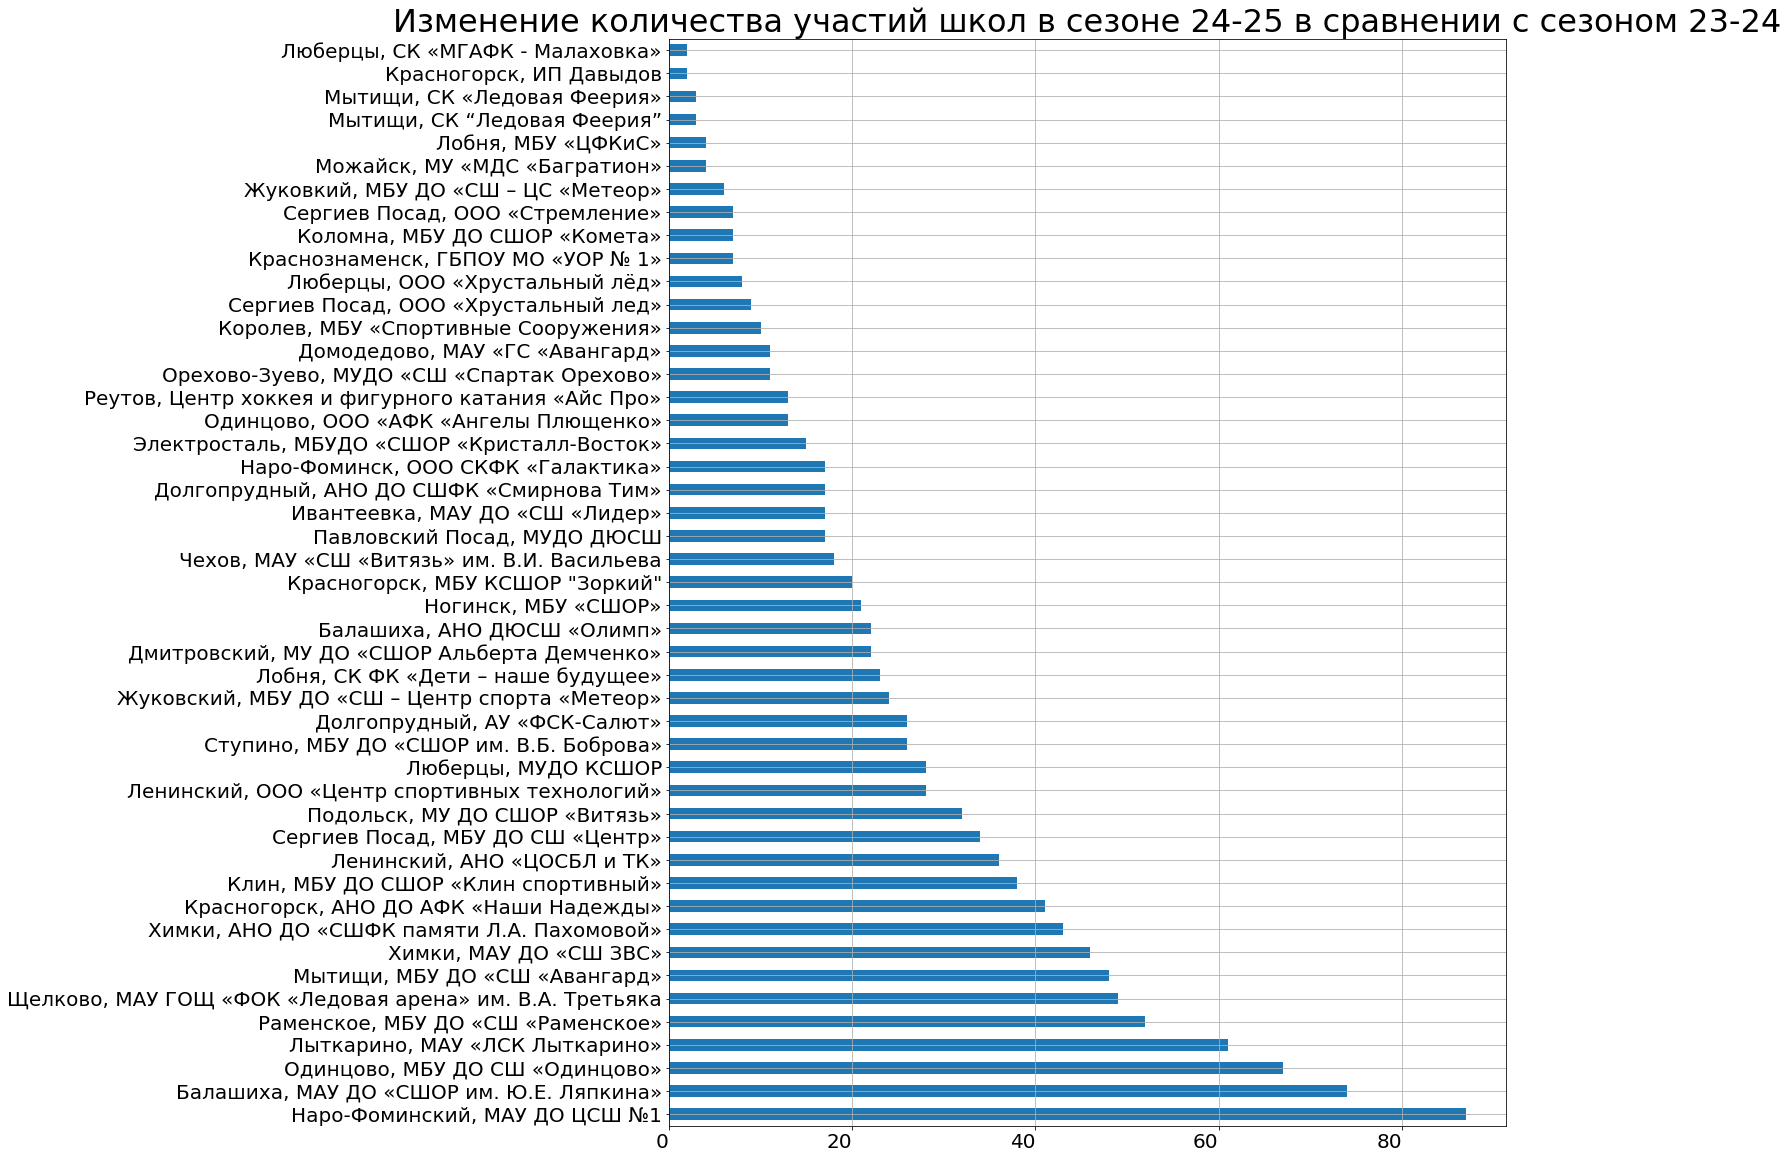

In [117]:
df_groupped = df.groupby(["firstname", "lastname", "club", "season"]).last().reset_index()
pivot_df = pd.pivot_table(df_groupped, values='date', index='club', columns='season', aggfunc='count')
tdf = pivot_df[2425]
tdf = tdf.dropna()
tdf.sort_values(ascending=False).plot(
    kind='barh', figsize=(15, 20), grid=True
)
plt.title("Изменение количества участий школ в сезоне 24-25 в сравнении с сезоном 23-24", fontsize=32)
plt.ylabel(f'', fontsize=18)
plt.yticks(fontsize=20, rotation=0, horizontalalignment='right');
plt.xticks(fontsize=20, rotation=0, horizontalalignment='right');

In [118]:
pd.set_option('display.max_rows', 100)
display(pivot_df.sort_values(by=2425, ascending=False))

season,2021,2122,2223,2324,2425
club,,,,,
"Наро-Фоминский, МАУ ДО ЦСШ №1",39.0,40.0,81.0,101.0,87.0
"Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»",95.0,90.0,76.0,80.0,74.0
"Одинцово, МБУ ДО СШ «Одинцово»",129.0,114.0,114.0,75.0,67.0
"Лыткарино, МАУ «ЛСК Лыткарино»",76.0,73.0,63.0,66.0,61.0
"Раменское, МБУ ДО «СШ «Раменское»",34.0,37.0,46.0,43.0,52.0
"Щелково, МАУ ГОЩ «ФОК «Ледовая арена» им. В.А. Третьяка",66.0,60.0,56.0,59.0,49.0
"Мытищи, МБУ ДО «СШ «Авангард»",65.0,62.0,49.0,49.0,48.0
"Химки, МАУ ДО «СШ ЗВС»",37.0,38.0,52.0,47.0,46.0
"Химки, АНО ДО «СШФК памяти Л.А. Пахомовой»",42.0,45.0,54.0,57.0,43.0


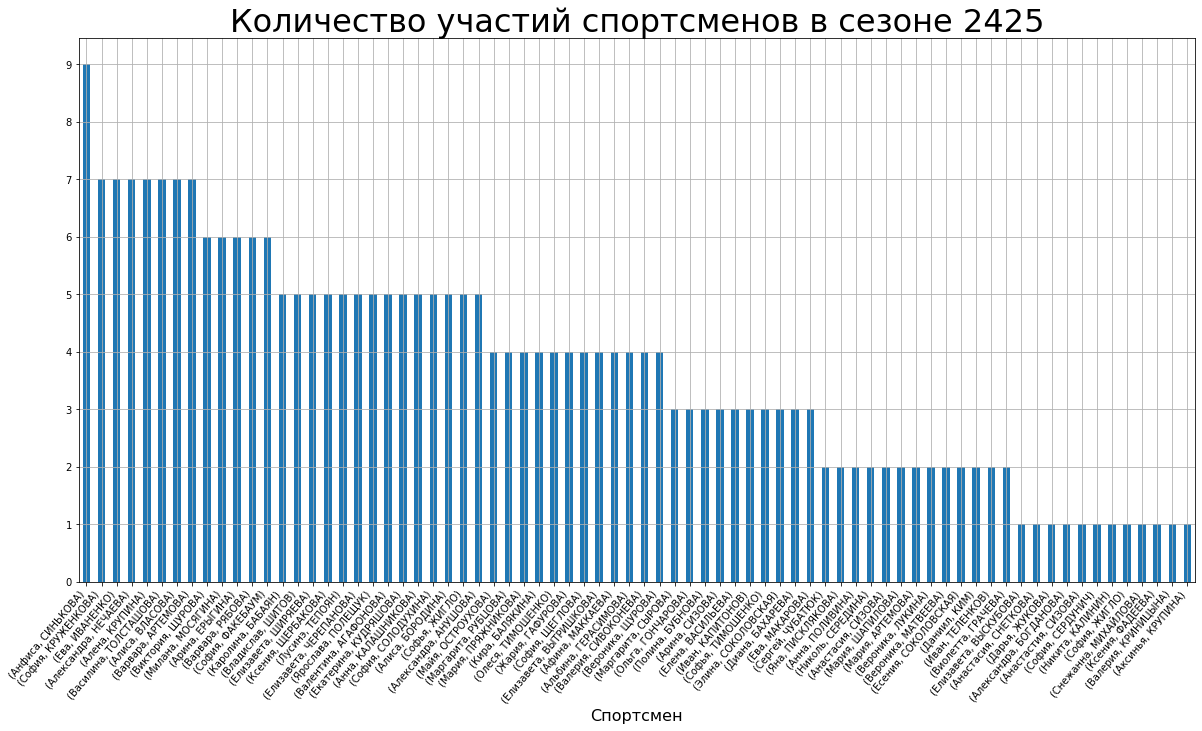

In [135]:
data = df[(df['segment']!='Короткая программа')&(df['club']==club.value)&(df['season']==season.value)]
data = data.groupby(['firstname', 'lastname']).count().sort_values(
    by='date', ascending=False)['date']
ax = data.plot(
    kind='bar', figsize=(20, 10), grid=True
)
major_ticks = np.arange(0, max(data) + 1, 1)
ax.set_yticks(major_ticks)
plt.title(f"Количество участий спортсменов в сезоне {season.value}", fontsize=32)
plt.xlabel('Спортсмен', fontsize=16)
plt.ylabel(f'', fontsize=18)
plt.xticks(fontsize=10, rotation=50, horizontalalignment='right');

In [131]:
idx = df[(df['lastname']=='СИНЬКОВА')].groupby(["category", "segment"])['tss'].idxmax()
df.loc[idx].groupby(["category", "segment"]).last()

,,date,place,online,rank,firstname,middlename,lastname,club,tss,tes,pcs,year,month,season
category,segment,,,,,,,,,,,,,,
"1-й юношеский разряд, девочки",Произвольная программа,2025-04-23,"г. Химки, ул. Мичурина, стр. 24, к. 1, ФОК ""Но...",http://ffkkmo.ru/events/2425/himki04/,1,Анфиса,None,СИНЬКОВА,"Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»",37.48,15.93,22.05,2025,4,2425
"2-й юношеский разряд, девочки",Произвольная программа,2025-01-23,"г. Ногинск, ул. Климова, 48, кор. А,ФОК Ледова...",http://ffkkmo.ru/events/2425/ng01/,1,Анфиса,None,СИНЬКОВА,"Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»",29.53,12.06,17.47,2025,1,2425
"3-й юношеский разряд, девочки",Произвольная программа,2024-03-19,"г. Щелково, ул. Фабричная, д. 4, Ледовая арена...",http://ffkkmo.ru/events/2324/schelkovo03/,1,Анфиса,None,СИНЬКОВА,"Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»",20.51,7.74,13.27,2024,3,2324
"Юный фигурист, девочки",Произвольная программа,2023-02-25,"г. Электросталь, ул. Радио, д. 3, ЛДС ""Кристалл""",http://ffkkmo.ru/events/2223/electrostal02/,2,Анфиса,None,СИНЬКОВА,"Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»",14.49,6.19,8.30,2023,2,2223


In [133]:
df[(df['lastname']=='СИНЬКОВА')].groupby(["category", "segment", "firstname", "lastname"]).count()["date"]

category                       segment                 firstname  lastname
1-й юношеский разряд, девочки  Произвольная программа  Анфиса     СИНЬКОВА    4
2-й юношеский разряд, девочки  Произвольная программа  Анфиса     СИНЬКОВА    5
3-й юношеский разряд, девочки  Произвольная программа  Анфиса     СИНЬКОВА    4
Юный фигурист, девочки         Произвольная программа  Анфиса     СИНЬКОВА    1
Name: date, dtype: int64

<Axes: >

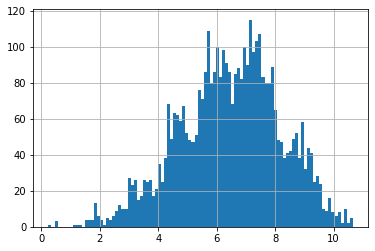

In [19]:
df[(df['category'] == '3-й юношеский разряд, девочки')]['tes'].hist(bins=100)

['3-й юношеский разряд, мальчики',
 '3-й юношеский разряд, девочки',
 '2-й юношеский разряд, мальчики',
 '2-й юношеский разряд, девочки',
 '1-й юношеский разряд, мальчики',
 '1-й юношеский разряд, девочки',
 '3-й спортивный разряд, мальчики',
 '3-й спортивный разряд, девочки',
 '2-й спортивный разряд, мальчики',
 '2-й спортивный разряд, мальчики',
 '2-й спортивный разряд, девочки',
 '2-й спортивный разряд, девочки',
 '1-й спортивный разряд, мальчики',
 '1-й спортивный разряд, мальчики',
 '1-й спортивный разряд, девочки',
 '1-й спортивный разряд, девочки']

In [20]:
tes_min = dict(zip([(x[0], x[1]) for x in ffkkmo_ra.sorter_names], [(x[2]) for x in ffkkmo_ra.sorter_names]))

In [21]:
def calc_procentage(x):
    return len(list(filter(lambda y : y > avg(x[1]), x[0]))) / len(x[0]) * 100

In [22]:
for x in tes_min:
    df.loc[(df['category'] == x[0]) & (df['segment'] == x[1]), 'tes_min'] = tes_min[x]
df['tes_done'] = df['tes'] >= df['tes_min']

In [40]:
df.category.unique()

array(['3-й юношеский разряд, мальчики', '3-й юношеский разряд, девочки',
       '2-й юношеский разряд, мальчики', '2-й юношеский разряд, девочки',
       '1-й юношеский разряд, мальчики', '1-й юношеский разряд, девочки',
       '3-й спортивный разряд, мальчики',
       '3-й спортивный разряд, девочки', '1-й спортивный разряд, девочки',
       '1-й спортивный разряд, мальчики',
       '2-й спортивный разряд, девочки',
       '2-й спортивный разряд, мальчики', 'МС, девушки', 'КМС, юноши',
       'Юный фигурист, девочки', 'Юный фигурист, мальчики',
       'Младшая группа, девочки', 'Младшая группа, мальчики',
       'Старшая группа, девочки', 'Старшая группа, мальчики', 'МС юноши'],
      dtype=object)

In [46]:
cats = list(set([x[0] for x in ffkkmo_ra.sorter_names]))

In [52]:
pvt = pd.pivot_table(
    df.query("category in @cats"), 
    values='tes_done', 
    index=['category', 'segment'], 
    columns='season', 
    aggfunc=lambda x : round(sum(x) / len(x) * 100, 2)
)
sorterIndex = dict(zip([(x[0], x[1]) for x in ffkkmo_ra.sorter_names], range(len(ffkkmo_ra.sorter_names))))
pvt['category_Rank'] = pvt.index.map(lambda x : sorterIndex[x])
pvt.sort_values('category_Rank', ascending = True, inplace = True)
pvt.drop('category_Rank', 1, inplace = True)
pvt

,season,2021,2122,2223,2324,2425
category,segment,,,,,
"3-й юношеский разряд, мальчики",Произвольная программа,92.86,90.22,48.61,42.37,56.25
"3-й юношеский разряд, девочки",Произвольная программа,88.48,89.13,60.18,50.08,54.78
"2-й юношеский разряд, мальчики",Произвольная программа,47.73,59.15,24.49,24.56,18.84
"2-й юношеский разряд, девочки",Произвольная программа,54.61,60.14,31.74,24.30,26.05
"1-й юношеский разряд, мальчики",Произвольная программа,29.17,45.59,33.33,66.67,44.44
"1-й юношеский разряд, девочки",Произвольная программа,45.10,48.91,54.22,56.77,58.28
"3-й спортивный разряд, мальчики",Произвольная программа,45.12,30.56,22.45,12.50,26.79
"3-й спортивный разряд, девочки",Произвольная программа,29.81,32.80,32.96,36.71,31.38
"2-й спортивный разряд, мальчики",Короткая программа,49.23,65.31,63.49,74.29,27.27


In [49]:
import seaborn as sns

<Axes: xlabel='season', ylabel='category-segment'>

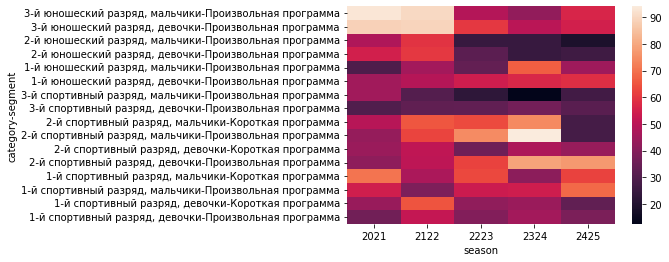

In [53]:
sns.heatmap(pvt)

In [35]:
pvt.index

,date,place,online,category,segment,rank,firstname,middlename,lastname,club,tss,tes,pcs,year,month,season,tes_min,tes_done


In [ ]:
pvt['2425'].plot(kind='barh')

In [ ]:
df['tes_pcs_ratio'] = df['tes']/df['pcs']

In [ ]:
df[(df['season'] == '2324')]['tes_pcs_ratio'].hist(bins=50, figsize=(15, 5), range=(0, 2))